# 🔬 End-to-End CZ Gate Optimisation for Rydberg Atom Arrays

## Goal

For **any given protocol**, **noise source configuration**, and **concrete apparatus budget** (laser power, temperature, atom spacing, etc.), **co-optimise gate fidelity (primary) and gate time (secondary)** — and achieve **≥ 99% fidelity** with any of the three protocols.

## Architecture at a Glance

```
    USER INPUTS                          ENTRY POINT                         OUTPUT
   ┌──────────────┐                ┌─────────────────────┐           ┌──────────────────┐
   │ Protocol:    │                │                     │           │ OptimizationResult│
   │  "lp"        │──┐             │  optimize_cz_gate() │──────────▶│  .best_fidelity   │
   │  "smooth_jp" │  │             │  [optimize_cz_gate  │           │  .best_params     │
   │  "jp_bangbang│  │             │        .py]         │           │  .gate_time_us    │
   └──────────────┘  │             └─────────┬───────────┘           │  .cost            │
   ┌──────────────┐  │                       │                      └──────────────────┘
   │ Apparatus:   │──┤   ┌───────────────────┼───────────────────┐
   │  laser_power │  │   │   FOR EACH CANDIDATE (DE optimizer)   │
   │  temperature │  │   │                                       │
   │  n_rydberg   │──┘   │  ┌─────────────┐   ┌──────────────┐  │
   │  tweezer_*   │      │  │ Build Sim    │   │ simulate_CZ  │  │
   │  B_field     │      │  │ Inputs from  │──▶│ _gate()      │  │
   └──────────────┘      │  │ apparatus +  │   │ [12-step     │  │
   ┌──────────────┐      │  │ trial params │   │  physics     │  │
   │ NoiseConfig  │──────┤  └─────────────┘   │  pipeline]   │  │
   └──────────────┘      │                     └──────┬───────┘  │
                         │  ┌─────────────┐   ┌──────▼───────┐  │
                         │  │ Simulation  │   │ extract_     │  │
                         │  │ Cache (JSON)│◀──│ metrics() +  │  │
                         │  │ memoisation │   │ compute_cost │  │
                         │  └─────────────┘   └──────────────┘  │
                         └───────────────────────────────────────┘
```

### The three CZ gate protocols

| Protocol | Key idea | Parameters | Reference |
|---|---|---|---|
| **Levine-Pichler (LP)** | Two pulses with static detuning Δ and phase jump ξ | δ/Ω, Ωτ (2D) | Levine et al., PRL 123, 170503 (2019) |
| **Smooth JP** | Single pulse with sinusoidal phase modulation φ(t) = A cos(ωt − ϕ) + δ₀t | Ωτ, A, ω_mod/Ω, ϕ, δ₀/Ω (5D) | Evered et al., Nature 622, 268 (2023) |
| **JP Bang-Bang** | Piecewise-constant phase switching (5 or 7 segments) — discrete variant selection | Ωτ, t₁…t_N (N+1 D) | Jandura & Pupillo, PRX Quantum 3, 010353 (2022) |

## 1. Import Libraries and Configure Environment

In [53]:
import sys, os, warnings, importlib
import numpy as np
import matplotlib.pyplot as plt

# Suppress noisy QuTiP warnings for cleaner notebook output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Matrix is singular")

# Force-reload the optimizer module in case source changed since last run
_mod_name = "qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.optimize_cz_gate"
if _mod_name in sys.modules:
    importlib.reload(sys.modules[_mod_name])

# ── Core optimizer imports ──────────────────────────────────────────
from qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.optimize_cz_gate import (
    optimize_cz_gate,       # Main entry point: protocol-agnostic optimizer
    ApparatusConstraints,   # Dataclass: fixed experimental budget
    SimulationCache,        # Disk-backed memoization cache
    run_baseline,           # Single sim with literature defaults
    compute_cost,           # Unified cost function
    extract_metrics,        # Pull fidelity/phase/timing from SimulationResult
    OptimizationResult,     # Return type
)

# ── Noise configuration ────────────────────────────────────────────
from qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.configurations import (
    NoiseSourceConfig,
)

# ── Protocol reference parameters ──────────────────────────────────
from qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.protocols import (
    LEVINE_PICHLER_PARAMS,
    SMOOTH_JP_PARAMS,
)

# ── Simulation engine (for manual runs / cost landscape) ───────────
from qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.simulation import (
    simulate_CZ_gate,
)
from qpu_simulator.micro_physics.neutral_atoms.rydberg_gates.configurations import (
    LPSimulationInputs,
)

# Plot style
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "font.size": 12,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

print("✅ All imports successful — optimizer, simulation engine, and cache ready.")

✅ All imports successful — optimizer, simulation engine, and cache ready.


## 2. Define Apparatus Constraints — Three Budget Tiers

Before we can simulate or optimize *anything*, we must specify what our lab actually has — laser powers, beam waists, atom temperature, etc. These are **fixed hardware parameters** the optimizer cannot change.

We define three tiers to explore how budget affects achievable fidelity:

| Tier | Laser Powers | Temperature | Rydberg n | Budget Scenario |
|------|-------------|-------------|-----------|-----------------|
| 🟢 **High** | 100 µW + 500 mW | 1 µK | 80 | State-of-the-art lab |
| 🟡 **Medium** | 50 µW + 300 mW | 2 µK | 70 | Typical research lab |
| 🔴 **Low** | 20 µW + 100 mW | 5 µK | 60 | Minimal / teaching lab |

**Physics recap:** Higher laser power → larger Rabi frequency Ω → faster gates. Lower temperature → less Doppler dephasing. Higher Rydberg n → stronger blockade V ∝ n¹¹ but shorter lifetime.

In [54]:
# ── Three apparatus budget tiers ───────────────────────────────────
apparatus_tiers = {
    "high": ApparatusConstraints(
        laser_1_power   = 100e-6,       # 100 µW  (780 nm)
        laser_1_waist   = 40e-6,        # 40 µm
        laser_2_power   = 0.5,          # 500 mW  (480 nm)
        laser_2_waist   = 25e-6,        # 25 µm
        Delta_e         = 2*np.pi*1e9,  # 1 GHz intermediate detuning
        temperature     = 1e-6,         # 1 µK  (deep cooling)
        spacing_factor  = 2.8,
        n_rydberg       = 80,           # |80S⟩
        species         = "Rb87",
        tweezer_power   = 0.030,
        tweezer_waist   = 0.8e-6,
        B_field         = 1e-4,
    ),
    "medium": ApparatusConstraints(
        laser_1_power   = 50e-6,        # 50 µW
        laser_1_waist   = 50e-6,        # 50 µm
        laser_2_power   = 0.3,          # 300 mW
        laser_2_waist   = 50e-6,        # 50 µm
        Delta_e         = 2*np.pi*1e9,
        temperature     = 2e-6,         # 2 µK
        spacing_factor  = 2.8,
        n_rydberg       = 70,           # |70S⟩
        species         = "Rb87",
        tweezer_power   = 0.020,
        tweezer_waist   = 0.8e-6,
        B_field         = 1e-4,
    ),
    "low": ApparatusConstraints(
        laser_1_power   = 20e-6,        # 20 µW
        laser_1_waist   = 60e-6,        # 60 µm
        laser_2_power   = 0.1,          # 100 mW
        laser_2_waist   = 60e-6,        # 60 µm
        Delta_e         = 2*np.pi*1e9,
        temperature     = 5e-6,         # 5 µK  (standard MOT)
        spacing_factor  = 3.0,          # wider spacing
        n_rydberg       = 60,           # |60S⟩
        species         = "Rb87",
        tweezer_power   = 0.015,
        tweezer_waist   = 1.0e-6,
        B_field         = 1e-4,
    ),
}

# Default apparatus for single-protocol demos
apparatus = apparatus_tiers["medium"]

tier_emoji = {"high": "🟢", "medium": "🟡", "low": "🔴"}
for tier_name, app in apparatus_tiers.items():
    print(f"\n{tier_emoji[tier_name]} {tier_name.upper()} budget  (fingerprint: {app.fingerprint()})")
    print(f"  Laser 1:  {app.laser_1_power*1e6:.0f} µW, waist {app.laser_1_waist*1e6:.0f} µm")
    print(f"  Laser 2:  {app.laser_2_power*1e3:.0f} mW, waist {app.laser_2_waist*1e6:.0f} µm")
    print(f"  Temp:     {app.temperature*1e6:.1f} µK")
    print(f"  n_Ryd:    {app.n_rydberg}")


🟢 HIGH budget  (fingerprint: c3487685fa33)
  Laser 1:  100 µW, waist 40 µm
  Laser 2:  500 mW, waist 25 µm
  Temp:     1.0 µK
  n_Ryd:    80

🟡 MEDIUM budget  (fingerprint: 54d39a34e7a6)
  Laser 1:  50 µW, waist 50 µm
  Laser 2:  300 mW, waist 50 µm
  Temp:     2.0 µK
  n_Ryd:    70

🔴 LOW budget  (fingerprint: e6ca824c7b69)
  Laser 1:  20 µW, waist 60 µm
  Laser 2:  100 mW, waist 60 µm
  Temp:     5.0 µK
  n_Ryd:    60


## 3. Baselines — Literature Defaults Across Budget Tiers

Before optimizing, let's measure what each protocol achieves with its **literature default** parameters (no tuning). We run baselines for the medium-budget apparatus, then show a quick comparison across all three tiers.

In [55]:
# ── Baselines: literature defaults, medium budget ──────────────────
protocols = ["lp", "jp_bangbang", "smooth_jp"]
baselines = {}
for proto in protocols:
    baselines[proto] = run_baseline(proto, apparatus, include_noise=False, verbose=True)

# Quick tier comparison for baselines
print(f"\n{'='*60}")
print(f"  Baseline fidelity across budget tiers")
print(f"{'='*60}")
print(f"  {'Protocol':<14s}", end="")
for tier in apparatus_tiers:
    print(f"  {tier_emoji[tier]} {tier:>7s}", end="")
print()
for proto in protocols:
    print(f"  {proto:<14s}", end="")
    for tier_name, app in apparatus_tiers.items():
        bl = run_baseline(proto, app, include_noise=False, verbose=False)
        print(f"    {bl['avg_fidelity']:.4f}", end="")
    print()

  V/Ω = 342.5 → using adapted protocol parameters
  LP protocol: Δ/Ω = 0.3772, Ωτ = 4.2928
  Zeeman shift: δ_z/(2π) = 575.0 Hz
  Stark shift:  δ_s/(2π) = 215304.8 Hz
  Trap laser during gate: True
Building Hamiltonians using unified builders (dim=3)
  Protocol: levine_pichler

  Baseline — lp
  Avg fidelity:     0.994423
  F(|11⟩):          0.977897
  CZ phase fid:     0.978587
  Phase error:      16.83°
  Ctrl phase:       163.17°
  Gate time:        0.379 µs
  V/Ω:              342.5
  Ω/2π:             3.602 MHz
  Cost (ref):       36.7118
  V/Ω = 342.5 → using adapted protocol parameters
  Smooth JP protocol (Bluvstein-form): Ωτ = 10.0900
  Phase modulation: A = 0.311π, ω_mod/Ω = 1.242
  Zeeman shift: δ_z/(2π) = 575.0 Hz
  Stark shift:  δ_s/(2π) = 215304.8 Hz
  Trap laser during gate: True
Building Hamiltonians using unified builders (dim=3)
  Protocol: smooth_jp
  Smooth JP → Bluvstein/Evered dark state CZ gate

BLUVSTEIN/EVERED SMOOTH SINUSOIDAL CZ GATE (DARK STATE)
Rabi frequenc

## 4. Understanding the Cost Function

Our optimizer uses a **unified cost function** that balances multiple objectives. All penalty terms are expressed in *percentage infidelity* (0–100 scale) so they're naturally comparable:

$$\text{Cost} = 10 \cdot (1 - F_\text{avg})^2 + 5 \cdot (1 - F_{|11\rangle})^2 + 2 \cdot (1 - F_{\phi_\text{CZ}})^2 + 0.01 \cdot t_\text{gate}$$

where all infidelity terms are in percent (multiplied by 100).

**Why this hierarchy?**
- **Overall fidelity** (×10): This is what matters for quantum computation — the average gate overlap across all computational basis states.
- **F(|11⟩)** (×5): The CZ gate's "hardest" state — both atoms attempt Rydberg excitation, and the blockade must perfectly suppress double excitation.
- **CZ phase fidelity** (×2): Ensures the controlled phase is exactly π. Defined as $\cos^2(\delta\phi/2)$ where $\delta\phi$ is the error from π.
- **Gate time** (×0.01): Very secondary — we prefer fast gates, but never at the cost of fidelity.

Let's visualize the cost breakdown for each baseline:

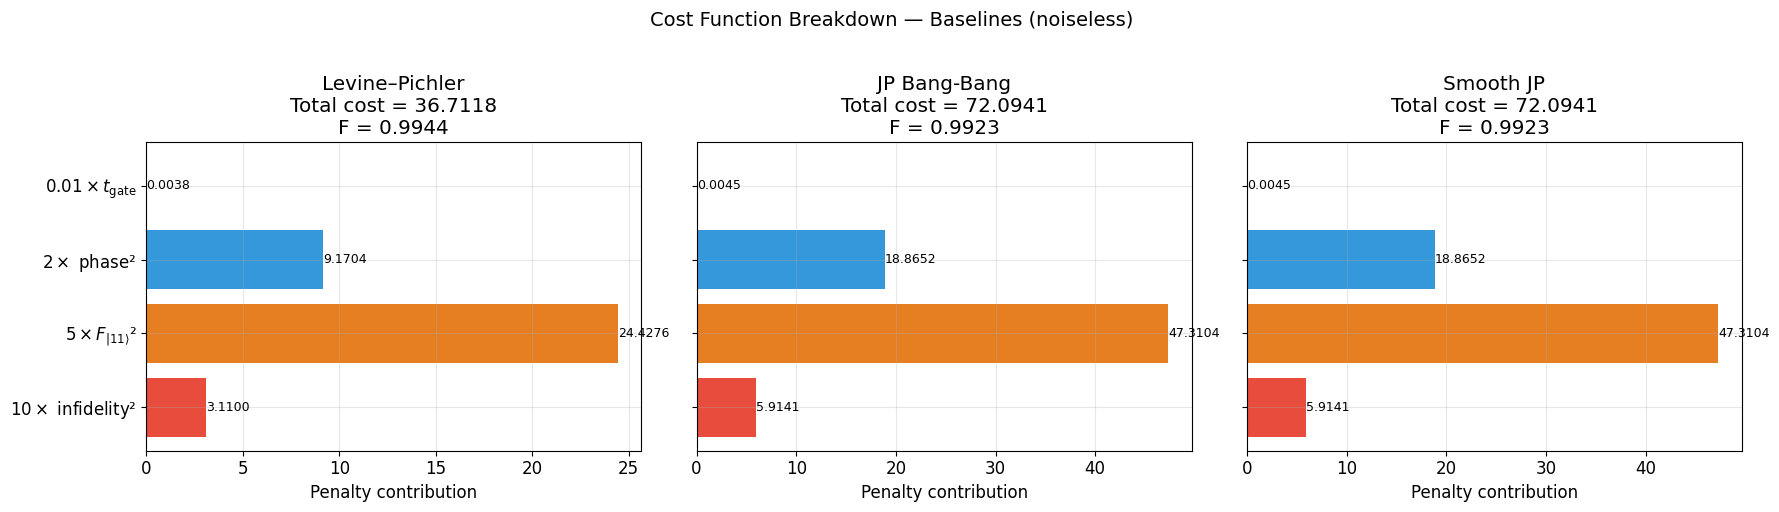

In [41]:
# ── Cost breakdown bar chart ───────────────────────────────────────
fig, axes = plt.subplots(1, len(protocols), figsize=(6 * len(protocols), 5), sharey=True)
if len(protocols) == 1:
    axes = [axes]
proto_labels = {"lp": "Levine–Pichler", "jp_bangbang": "JP Bang-Bang", "smooth_jp": "Smooth JP"}

for ax, proto in zip(axes, protocols):
    m = baselines[proto]
    infid_pct   = (1 - m["avg_fidelity"]) * 100
    f11_pct     = (1 - m["f11"]) * 100
    phase_pct   = (1 - m["cz_phase_fidelity"]) * 100
    t_gate      = m["gate_time_us"]

    # Compute each penalty term
    penalties = {
        r"$10 \times$ infidelity²":  10 * infid_pct**2,
        r"$5 \times F_{|11\rangle}$²": 5 * f11_pct**2,
        r"$2 \times$ phase²":       2 * phase_pct**2,
        r"$0.01 \times t_\mathrm{gate}$": 0.01 * t_gate,
    }
    total = sum(penalties.values())

    colors = ["#e74c3c", "#e67e22", "#3498db", "#95a5a6"]
    bars = ax.barh(list(penalties.keys()), list(penalties.values()), color=colors)
    ax.set_xlabel("Penalty contribution")
    ax.set_title(f"{proto_labels.get(proto, proto)}\nTotal cost = {total:.4f}\nF = {m['avg_fidelity']:.4f}")

    for bar, val in zip(bars, penalties.values()):
        if val > 0.001:
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f"{val:.4f}", va="center", fontsize=9)

fig.suptitle("Cost Function Breakdown — Baselines (noiseless)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Optimize All Three Protocols (Noiseless)

We optimize each protocol with **differential evolution** using `optimize_spacing=True` — this lets the optimizer also vary the inter-atom spacing to find the best $V/\Omega$ ratio, which is critical for the bang-bang protocol.

| Protocol | Free Parameters | Spacing? | Expected Runtime |
|----------|----------------|----------|-----------------|
| **LP** | δ/Ω, Ωτ (2D) + spacing_factor | 3D total | ~30 s |
| **JP Bang-Bang** | Ωτ, fractions, phases (10D for 5-seg) + spacing_factor | 11D total | ~5–10 min |
| **Smooth JP** | Ωτ, A, ω_mod/Ω, ϕ, δ₀/Ω (5D) + spacing_factor | 6D total | ~2–4 min |

> 💡 The `optimize_spacing` flag appends `spacing_factor` as an extra dimension — the optimizer finds the atom separation that gives the best blockade strength $V/\Omega$ for each protocol. This is especially important for JP bang-bang, whose switching times are sensitive to $V/\Omega$.

In [49]:
# ── Optimize all three protocols (noiseless, with spacing optimisation) ──
# Bang-bang wants V/Ω ≈ 7 (spacing ≈ 5.3), so we allow spacing up to 5.5.
# LP and smooth JP peak at spacing ≈ 4.5 (V/Ω ≈ 20), naturally found by the optimizer.
opt_config = {
    "lp":          {"maxiter": 80,  "popsize": 15},
    "jp_bangbang": {"maxiter": 300, "popsize": 25},
    "smooth_jp":   {"maxiter": 80,  "popsize": 15},
}

opt_results = {}
for proto in protocols:
    cfg = opt_config[proto]
    print(f"\n{'━'*70}")
    print(f"  Optimizing: {proto}")
    print(f"{'━'*70}")
    opt_results[proto] = optimize_cz_gate(
        protocol=proto,
        apparatus=apparatus,
        include_noise=False,
        optimize_spacing=True,
        spacing_bounds=(2.0, 5.5),
        maxiter=cfg["maxiter"],
        popsize=cfg["popsize"],
        verbose=True,
    )
    m = opt_results[proto].best_metrics
    status = "✅" if m["avg_fidelity"] >= 0.99 else "❌"
    print(f"\n  🎯 {proto}: F = {m['avg_fidelity']:.6f}, "
          f"φ_err = {m['phase_error_deg']:.2f}°, "
          f"V/Ω = {m['V_over_Omega']:.1f}  {status}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Optimizing: lp
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  CZ Gate Optimisation — lp
  Species: Rb87, n_rydberg: 70
  Spacing factor: 2.8 (will be optimised)
  Noise: OFF
  Laser 1: 50 µW, waist 50 µm
  Laser 2: 300 mW, waist 50 µm
  Delta_e/2π: 1.00 GHz
  Temperature: 2.0 µK
----------------------------------------------------------------------
    Spacing optimisation ON: bounds=(2.0, 5.5), x0=2.80
    Starting differential_evolution: maxiter=80, popsize=15, dim=3, strategy=standard
    x0 = [0.377371 4.29268  2.8     ]
    [   2] cost=  520.9622  F=0.978734  F11=0.916426  CZφ=0.9205  φ_err=32.76°  t=0.393µs  V/Ω=10.3
    [   3] cost=    6.9677  F=0.996975  F11=0.989012  CZφ=0.9992  φ_err=3.19°  t=0.361µs  V/Ω=17.1
    [  10] cost=    4.9670  F=0.997284  F11=0.991089  CZφ=0.9964  φ_err=6.86°  t=0.368µs  V/Ω=182.8


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.9 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.1 < 10. Blockade too weak for reliable CZ gate!
  


    [  27] cost=    0.3884  F=0.999107  F11=0.997532  CZφ=0.9999  φ_err=1.28°  t=0.369µs  V/Ω=21.3


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.7 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.0 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.7 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.2 < 10. Blockade too we

    [  75] cost=    0.0465  F=0.999639  F11=0.999349  CZφ=0.9993  φ_err=2.92°  t=0.378µs  V/Ω=1089.7


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.5 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.3 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.0 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.1 < 10. Blockade too we

    [ 120] cost=    0.0144  F=0.999718  F11=0.999778  CZφ=0.9999  φ_err=1.11°  t=0.381µs  V/Ω=645.2


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.9 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.2 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.8 < 10. Blockade too weak for reliable CZ gate!
  


    [ 171] cost=    0.0140  F=0.999708  F11=0.999843  CZφ=0.9998  φ_err=1.41°  t=0.379µs  V/Ω=360.0
    [ 181] cost=    0.0124  F=0.999720  F11=0.999892  CZφ=0.9999  φ_err=1.15°  t=0.379µs  V/Ω=1692.4


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.8 < 10. Blockade too weak for reliable CZ gate!
  


    [ 229] cost=    0.0109  F=0.999762  F11=0.999831  CZφ=1.0000  φ_err=0.65°  t=0.380µs  V/Ω=90.5
    [ 234] cost=    0.0096  F=0.999762  F11=0.999955  CZφ=1.0000  φ_err=0.71°  t=0.378µs  V/Ω=280.1
    [ 244] cost=    0.0094  F=0.999769  F11=0.999940  CZφ=1.0000  φ_err=0.64°  t=0.380µs  V/Ω=920.5


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.6 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.8 < 10. Blockade too weak for reliable CZ gate!
  


    [ 379] cost=    0.0092  F=0.999770  F11=0.999957  CZφ=1.0000  φ_err=0.42°  t=0.380µs  V/Ω=1821.4
    [ 413] cost=    0.0091  F=0.999777  F11=0.999919  CZφ=1.0000  φ_err=0.46°  t=0.379µs  V/Ω=44.3


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.7 < 10. Blockade too weak for reliable CZ gate!
  


    [ 440] cost=    0.0081  F=0.999792  F11=0.999981  CZφ=1.0000  φ_err=0.11°  t=0.377µs  V/Ω=29.8
    [ 451] cost=    0.0081  F=0.999794  F11=0.999971  CZφ=1.0000  φ_err=0.43°  t=0.377µs  V/Ω=29.8
    [ 452] cost=    0.0074  F=0.999810  F11=0.999996  CZφ=1.0000  φ_err=0.03°  t=0.377µs  V/Ω=24.7


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.6 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.5 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.6 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.4 < 10. Blockade too we

    [ 627] cost=    0.0074  F=0.999814  F11=0.999948  CZφ=1.0000  φ_err=0.14°  t=0.377µs  V/Ω=19.9
    [ 646] cost=    0.0068  F=0.999829  F11=0.999959  CZφ=1.0000  φ_err=0.03°  t=0.377µs  V/Ω=16.0


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.4 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.4 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 10.0 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.2 < 10. Blockade too w

    [ 676] cost=    0.0065  F=0.999834  F11=0.999988  CZφ=1.0000  φ_err=0.37°  t=0.376µs  V/Ω=16.0
    [ 739] cost=    0.0058  F=0.999860  F11=0.999956  CZφ=1.0000  φ_err=0.66°  t=0.373µs  V/Ω=10.2


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.3 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.0 < 10. Blockade too weak for reliable CZ gate!
  


    [ 806] cost=    0.0055  F=0.999866  F11=0.999987  CZφ=1.0000  φ_err=0.38°  t=0.374µs  V/Ω=10.2


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.5 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.2 < 10. Blockade too weak for reliable CZ gate!
  


    [ 866] cost=    0.0053  F=0.999875  F11=0.999975  CZφ=1.0000  φ_err=0.20°  t=0.372µs  V/Ω=8.7


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.1 < 10. Blockade too weak for reliable CZ gate!
  


    [ 935] cost=    0.0051  F=0.999881  F11=0.999986  CZφ=1.0000  φ_err=0.26°  t=0.373µs  V/Ω=8.8
    [1057] cost=    0.0051  F=0.999883  F11=0.999985  CZφ=1.0000  φ_err=0.01°  t=0.373µs  V/Ω=8.5
    [1111] cost=    0.0050  F=0.999885  F11=0.999996  CZφ=1.0000  φ_err=0.09°  t=0.373µs  V/Ω=8.7


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.4 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 9.3 < 10. Blockade too weak for reliable CZ gate!
  


    [1368] cost=    0.0047  F=0.999904  F11=0.999964  CZφ=1.0000  φ_err=0.16°  t=0.373µs  V/Ω=7.2
    [1391] cost=    0.0047  F=0.999903  F11=0.999966  CZφ=1.0000  φ_err=0.00°  t=0.373µs  V/Ω=7.2
    [1393] cost=    0.0046  F=0.999906  F11=0.999978  CZφ=1.0000  φ_err=0.26°  t=0.373µs  V/Ω=7.3
    [1523] cost=    0.0046  F=0.999907  F11=0.999995  CZφ=1.0000  φ_err=0.15°  t=0.372µs  V/Ω=7.2
    [1590] cost=    0.0046  F=0.999908  F11=0.999997  CZφ=1.0000  φ_err=0.12°  t=0.372µs  V/Ω=7.2
    [1888] cost=    0.0046  F=0.999909  F11=0.999986  CZφ=1.0000  φ_err=0.38°  t=0.372µs  V/Ω=6.9
    [1890] cost=    0.0044  F=0.999917  F11=0.999998  CZφ=1.0000  φ_err=0.05°  t=0.372µs  V/Ω=6.9
    [1896] cost=    0.0044  F=0.999918  F11=0.999997  CZφ=1.0000  φ_err=0.15°  t=0.372µs  V/Ω=6.9
    [1901] cost=    0.0044  F=0.999918  F11=0.999997  CZφ=1.0000  φ_err=0.12°  t=0.372µs  V/Ω=6.9
    [2103] cost=    0.0044  F=0.999918  F11=0.999995  CZφ=1.0000  φ_err=0.18°  t=0.372µs  V/Ω=6.9
    [2135] cost=    

## 6. Protocol Comparison + Multi-Tier Optimization

Now we compare all three protocols side-by-side, then run a **full tier sweep** — optimizing each protocol (with spacing optimisation) for every budget tier. The ≥ 99% fidelity goal line is shown in charts.

  PROTOCOL COMPARISON — Medium Budget (noiseless, spacing optimised)
  Protocol        Baseline F  Optimized F  Phase err  Gate time    V/Ω     Cost  ≥99%?
----------------------------------------------------------------------------------
  lp                0.994423     0.999918      0.17°     0.372µs      7   0.0044      ✅
  jp_bangbang       0.992310     0.999959      0.49°     0.447µs      7   0.0047      ✅
  smooth_jp         0.992310     0.999996      0.04°     0.428µs    893   0.0043      ✅

  MULTI-TIER OPTIMIZATION SWEEP (noiseless, spacing optimised)

  🟢 HIGH tier...
    lp            : F=0.999988  ✅
    jp_bangbang   : F=0.999999  ✅
    smooth_jp     : F=0.999999  ✅

  🟡 MEDIUM tier...
    lp            : F=0.999918  ✅
    jp_bangbang   : F=0.999959  ✅
    smooth_jp     : F=0.999547  ✅

  🔴 LOW tier...


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 5.6 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 4.1 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 4.9 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 3.2 < 10. Blockade too we

    lp            : F=0.999789  ✅


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/simulation.py:1672: UserWarning: V/Ω = 4.2 may be too weak for reliable CZ operation. Recommend V/Ω > 10 for high-fidelity gates.
  warnings.warn(
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/simulation.py:1672: UserWarning: V/Ω = 4.1 may be too weak for reliable CZ operation. Recommend V/Ω > 10 for high-fidelity gates.
  warnings.warn(
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/simulation.py:1672: UserWarning: V/Ω = 4.0 may be too weak for reliable CZ operation. Recommend V/Ω > 10 for high-fidelity gates.
  warnings.warn(
/Users/scottjones_admin/Library/Mobile Documents/com~apple

    jp_bangbang   : F=0.999748  ✅
    smooth_jp     : F=0.999987  ✅

  Protocol        🟢     high  🟡   medium  🔴      low
  --------------  -----------  -----------  -----------
  lp              0.999988 ✅  0.999918 ✅  0.999789 ✅
  jp_bangbang     0.999999 ✅  0.999959 ✅  0.999748 ✅
  smooth_jp       0.999999 ✅  0.999547 ✅  0.999987 ✅


/var/folders/wb/b8rfjwj12jn7gld5g0b3c2x80000gn/T/ipykernel_5484/663004081.py:104: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wb/b8rfjwj12jn7gld5g0b3c2x80000gn/T/ipykernel_5484/663004081.py:104: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wb/b8rfjwj12jn7gld5g0b3c2x80000gn/T/ipykernel_5484/663004081.py:104: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/my_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/my_venv/lib/python3.11/site

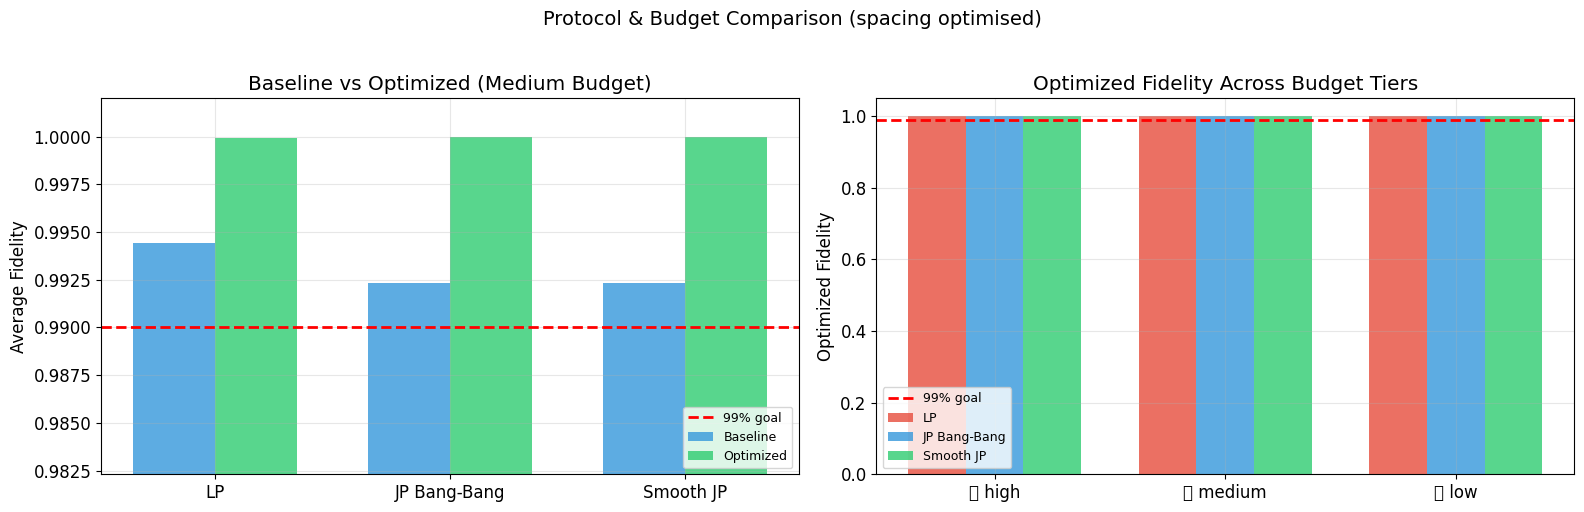

In [51]:
# ── Summary table (medium budget) ──────────────────────────────────
proto_labels = {"lp": "LP", "jp_bangbang": "JP Bang-Bang", "smooth_jp": "Smooth JP"}

header = (f"  {'Protocol':<14} {'Baseline F':>11} {'Optimized F':>12} "
          f"{'Phase err':>10} {'Gate time':>10} {'V/Ω':>6} {'Cost':>8} {'≥99%?':>6}")
print("=" * 82)
print("  PROTOCOL COMPARISON — Medium Budget (noiseless, spacing optimised)")
print("=" * 82)
print(header)
print("-" * 82)
for p in protocols:
    bl_f = baselines[p]["avg_fidelity"]
    opt_m = opt_results[p].best_metrics
    opt_f = opt_m["avg_fidelity"]
    status = "✅" if opt_f >= 0.99 else "❌"
    print(f"  {p:<14} {bl_f:11.6f} {opt_f:12.6f} "
          f"{opt_m['phase_error_deg']:9.2f}° "
          f"{opt_m['gate_time_us']:9.3f}µs "
          f"{opt_m['V_over_Omega']:6.0f} "
          f"{opt_results[p].best_cost:8.4f} {status:>6}")

# ── Multi-tier optimization sweep (with spacing optimisation) ─────
print(f"\n{'='*82}")
print("  MULTI-TIER OPTIMIZATION SWEEP (noiseless, spacing optimised)")
print(f"{'='*82}")

# Tier-specific iteration budgets: bang-bang needs more
tier_opt_config = {
    "lp":          {"maxiter": 60,  "popsize": 12},
    "jp_bangbang": {"maxiter": 200, "popsize": 20},
    "smooth_jp":   {"maxiter": 60,  "popsize": 12},
}

tier_results = {}
for tier_name, app in apparatus_tiers.items():
    tier_results[tier_name] = {}
    print(f"\n  {tier_emoji[tier_name]} {tier_name.upper()} tier...")
    for proto in protocols:
        cfg = tier_opt_config[proto]
        r = optimize_cz_gate(
            protocol=proto, apparatus=app, include_noise=False,
            optimize_spacing=True, spacing_bounds=(2.0, 5.5),
            maxiter=cfg["maxiter"], popsize=cfg["popsize"], verbose=False,
        )
        tier_results[tier_name][proto] = r
        f = r.best_metrics["avg_fidelity"]
        mark = "✅" if f >= 0.99 else "⚠️"
        print(f"    {proto:<14s}: F={f:.6f}  {mark}")

# Print sweep table
print(f"\n  {'Protocol':<14}", end="")
for tier in apparatus_tiers:
    print(f"  {tier_emoji[tier]} {tier:>8s}", end="")
print()
print(f"  {'-'*14}", end="")
for _ in apparatus_tiers:
    print(f"  {'-'*11}", end="")
print()
for proto in protocols:
    print(f"  {proto:<14}", end="")
    for tier_name in apparatus_tiers:
        f = tier_results[tier_name][proto].best_metrics["avg_fidelity"]
        mark = "✅" if f >= 0.99 else "⚠️"
        print(f"  {f:.6f} {mark}", end="")
    print()

# ── Charts: fidelity comparison ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: baseline vs optimized (medium)
x = np.arange(len(protocols))
width = 0.35
bl_vals = [baselines[p]["avg_fidelity"] for p in protocols]
opt_vals = [opt_results[p].best_metrics["avg_fidelity"] for p in protocols]

axes[0].bar(x - width/2, bl_vals, width, label="Baseline", color="#3498db", alpha=0.8)
axes[0].bar(x + width/2, opt_vals, width, label="Optimized", color="#2ecc71", alpha=0.8)
axes[0].axhline(y=0.99, color="red", linestyle="--", linewidth=2, label="99% goal")
axes[0].set_ylabel("Average Fidelity")
axes[0].set_xticks(x)
axes[0].set_xticklabels([proto_labels.get(p, p) for p in protocols])
axes[0].set_ylim(min(min(bl_vals), min(opt_vals)) - 0.01, 1.002)
axes[0].legend(loc="lower right", fontsize=9)
axes[0].set_title("Baseline vs Optimized (Medium Budget)")

# Right: tier comparison (all three protocols)
x = np.arange(len(apparatus_tiers))
colors = {"lp": "#e74c3c", "jp_bangbang": "#3498db", "smooth_jp": "#2ecc71"}
bar_width = 0.25
for i, proto in enumerate(protocols):
    vals = [tier_results[t][proto].best_metrics["avg_fidelity"]
            for t in apparatus_tiers]
    axes[1].bar(x + (i - 1) * bar_width, vals, bar_width,
                label=proto_labels.get(proto, proto),
                color=colors.get(proto, "#999"), alpha=0.8)
axes[1].axhline(y=0.99, color="red", linestyle="--", linewidth=2, label="99% goal")
axes[1].set_ylabel("Optimized Fidelity")
axes[1].set_xticks(x)
axes[1].set_xticklabels([f"{tier_emoji[t]} {t}" for t in apparatus_tiers])
axes[1].legend(fontsize=9)
axes[1].set_title("Optimized Fidelity Across Budget Tiers")

fig.suptitle("Protocol & Budget Comparison (spacing optimised)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Adding Noise — All Three Protocols Under Realistic Conditions

Real experiments suffer from multiple noise sources. We define three regimes to bracket uncertainty:

| Regime | Noise Sources Enabled | Scenario |
|--------|----------------------|----------|
| 🟢 **Optimistic** | Spontaneous emission + intermediate scattering only | Ideal cooling, quiet lasers |
| 🟡 **Expected** | + Motional dephasing + Doppler dephasing | Standard lab conditions |
| 🔴 **Pessimistic** | + Intensity noise + laser dephasing + magnetic dephasing | Noisy environment |

We re-optimize **all three protocols** under each regime with `optimize_spacing=True` and show how fidelity degrades (or holds up!) across noise levels.

In [ ]:
# ── Three noise regimes ────────────────────────────────────────────
noise_regimes = {
    "optimistic": NoiseSourceConfig(
        include_spontaneous_emission=True,
        include_intermediate_scattering=True,
        include_motional_dephasing=False,
        include_doppler_dephasing=False,
        include_intensity_noise=False,
        include_laser_dephasing=False,
        include_magnetic_dephasing=False,
    ),
    "expected": NoiseSourceConfig(
        include_spontaneous_emission=True,
        include_intermediate_scattering=True,
        include_motional_dephasing=True,
        include_doppler_dephasing=True,
        include_intensity_noise=False,
        include_laser_dephasing=False,
        include_magnetic_dephasing=False,
    ),
    "pessimistic": NoiseSourceConfig(
        include_spontaneous_emission=True,
        include_intermediate_scattering=True,
        include_motional_dephasing=True,
        include_doppler_dephasing=True,
        include_intensity_noise=True,
        intensity_noise_frac=0.01,
        include_laser_dephasing=True,
        include_magnetic_dephasing=True,
    ),
}

regime_emoji = {"optimistic": "🟢", "expected": "🟡", "pessimistic": "🔴"}

# Iteration budget per protocol for noisy optimisation
# Bang-bang needs large budget for its 15D (7-seg + spacing) search space
noisy_opt_config = {
    "lp":          {"maxiter": 80,  "popsize": 15},
    "jp_bangbang": {"maxiter": 300, "popsize": 25},
    "smooth_jp":   {"maxiter": 80,  "popsize": 15},
}

# ── Re-optimize ALL protocols under each noise regime ──────────────
noise_results = {}  # noise_results[regime][proto] = {baseline_F, optimized_F, ...}

for regime, noise_cfg in noise_regimes.items():
    print(f"\n{'='*70}")
    print(f"  {regime_emoji[regime]} {regime.upper()} noise regime")
    print(f"{'='*70}")
    noise_results[regime] = {}

    for proto in protocols:
        cfg = noisy_opt_config[proto]

        # Noisy baseline
        bl = run_baseline(proto, apparatus, include_noise=True, verbose=False)

        # Re-optimize with spacing — wider bounds allow BB to find V/Ω≈7
        result_n = optimize_cz_gate(
            protocol=proto,
            apparatus=apparatus,
            include_noise=True,
            noise_config=noise_cfg,
            optimize_spacing=True,
            spacing_bounds=(2.0, 5.5),
            maxiter=cfg["maxiter"],
            popsize=cfg["popsize"],
            verbose=False,
        )
        f_opt = result_n.best_metrics["avg_fidelity"]
        noise_results[regime][proto] = {
            "baseline_F": bl["avg_fidelity"],
            "optimized_F": f_opt,
            "phase_error": result_n.best_metrics["phase_error_deg"],
            "v_omega": result_n.best_metrics.get("V_over_Omega", 0),
            "gate_time": result_n.best_metrics.get("gate_time_us", 0),
            "params": dict(zip(result_n.param_names, result_n.best_params)),
            "result": result_n,
        }
        status = "✅" if f_opt >= 0.99 else "⚠️"
        print(f"  {proto:<14s}: baseline F={bl['avg_fidelity']:.6f} → "
              f"optimised F={f_opt:.6f}, φ_err={result_n.best_metrics['phase_error_deg']:.2f}°  {status}")

# ── Summary comparison table ───────────────────────────────────────
print(f"\n{'='*82}")
print(f"  NOISE REGIME COMPARISON — All Protocols (spacing optimised)")
print(f"{'='*82}")
print(f"  {'Protocol':<14s}  {'Regime':<12s}  {'Baseline F':>11s}  "
      f"{'Optimized F':>12s}  {'Phase Err':>10s}  {'V/Ω':>6s}")
print(f"  {'-'*14}  {'-'*12}  {'-'*11}  {'-'*12}  {'-'*10}  {'-'*6}")
for proto in protocols:
    for regime in noise_regimes:
        data = noise_results[regime][proto]
        mark = "✅" if data["optimized_F"] >= 0.99 else "⚠️"
        print(f"  {proto:<14s}  {regime_emoji[regime]} {regime:<9s}  "
              f"{data['baseline_F']:>11.6f}  {data['optimized_F']:>12.6f}  "
              f"{data['phase_error']:>9.2f}°  {data['v_omega']:>5.0f}  {mark}")
    print()

# ── Chart: noise regime comparison ─────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(noise_regimes))
bar_width = 0.25
colors = {"lp": "#e74c3c", "jp_bangbang": "#3498db", "smooth_jp": "#2ecc71"}

for i, proto in enumerate(protocols):
    vals = [noise_results[regime][proto]["optimized_F"] for regime in noise_regimes]
    ax.bar(x + (i - 1) * bar_width, vals, bar_width,
           label=proto_labels[proto], color=colors[proto], alpha=0.85)

ax.axhline(y=0.99, color="red", linestyle="--", linewidth=2, label="99% goal")
ax.set_ylabel("Optimized Fidelity")
ax.set_xticks(x)
ax.set_xticklabels([f"{regime_emoji[r]} {r}" for r in noise_regimes])
ax.legend(fontsize=10)
ax.set_ylim(0.96, 1.002)
ax.set_title("All Protocols Under Noise (spacing optimised, medium budget)")
plt.tight_layout()
plt.show()


  🟢 OPTIMISTIC noise regime


/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.9 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 8.1 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 6.0 < 10. Blockade too weak for reliable CZ gate!
  
/Users/scottjones_admin/Library/Mobile Documents/com~apple~CloudDocs/Mac files/Repos/NoisyQuantumSimulator/src/qpu_simulator/micro_physics/neutral_atoms/rydberg_gates/protocols.py:624: UserWarning: V/Ω = 7.7 < 10. Blockade too we

  lp            : baseline F=0.964739 → optimised F=0.971303, φ_err=0.27°  ⚠️


## 8. Memoization Cache — Reuse Across Runs

The `SimulationCache` avoids redundant simulations by storing results keyed by `(protocol, rounded_params, apparatus_hash)`. This is critical when:

- Running the optimizer (many similar parameter evaluations)
- Sweeping a parameter (neighbouring points often repeat)
- Restarting a notebook (load previous cache from disk)

Let's demonstrate saving and reloading:

In [11]:
# ── SimulationCache demo ───────────────────────────────────────────
import tempfile

# Create a fresh cache and run an optimization that populates it
cache = SimulationCache(precision=4)

result_cached = optimize_cz_gate(
    protocol="lp",
    apparatus=apparatus,
    include_noise=False,
    maxiter=20,          # Quick run to populate cache
    popsize=10,
    cache=cache,
    verbose=False,
)

print(f"Cache populated with {len(cache)} entries after LP optimization.")
print(f"Cache hits: {cache.hits}, misses: {cache.misses}")
print(f"Hit rate:   {cache.hit_rate:.1%}")

# Save to disk
cache_file = os.path.join(tempfile.gettempdir(), "cz_demo_cache.json")
cache.save(cache_file)
print(f"\n💾 Cache saved to {cache_file}")
print(f"   File size: {os.path.getsize(cache_file) / 1024:.1f} KB")

# Reload into a new cache and re-run — should be instant
cache2 = SimulationCache(precision=4)
cache2.load(cache_file)
print(f"\n📂 Cache reloaded: {len(cache2)} entries")

# Re-optimize with the loaded cache — should get many cache hits
result_cached2 = optimize_cz_gate(
    protocol="lp",
    apparatus=apparatus,
    include_noise=False,
    maxiter=20,
    popsize=10,
    cache=cache2,
    verbose=False,
)
print(f"Re-run cache hits: {cache2.hits} (vs {cache2.misses} misses)")
print(f"Re-run hit rate:   {cache2.hit_rate:.1%}")

# Clean up
os.remove(cache_file)
print(f"\n🗑️  Cache file cleaned up.")

Cache populated with 385 entries after LP optimization.
Cache hits: 39, misses: 385
Hit rate:   9.2%

💾 Cache saved to /var/folders/wb/b8rfjwj12jn7gld5g0b3c2x80000gn/T/cz_demo_cache.json
   File size: 208.5 KB

📂 Cache reloaded: 385 entries
Re-run cache hits: 424 (vs 0 misses)
Re-run hit rate:   100.0%

🗑️  Cache file cleaned up.


## 9. Laser Power Sweep — How Does Fidelity Depend on Hardware?

A key question for experimental design: *How much laser power do we actually need?*

The second-leg laser power directly controls the two-photon Rabi frequency Ω, which in turn sets:
- **Gate time**: $t_\text{gate} = \Omega\tau / \Omega$ (proportional to 1/Ω)
- **Blockade ratio**: $V/\Omega$ (inversely proportional to Ω — higher power means *weaker* blockade!)

There's an inherent tradeoff: more power → faster gate → less time for decoherence, but also → weaker blockade → more leakage error. Let's sweep laser power to see where the optimum lies:

Sweeping second-leg laser power for LP protocol (noiseless baselines)...
     Power     F_avg       V/Ω      t_gate     φ_err
--------------------------------------------------
      50 mW  0.969304     839.0     0.929 µs    40.21°
     100 mW  0.983722     593.2     0.657 µs    29.01°
     200 mW  0.991645     419.5     0.465 µs    20.66°
     300 mW  0.994423     342.5     0.379 µs    16.83°
     500 mW  0.996704     265.3     0.294 µs    12.90°
    1000 mW  0.998474     187.6     0.208 µs     8.72°
    2000 mW  0.999423     132.6     0.147 µs     5.23°


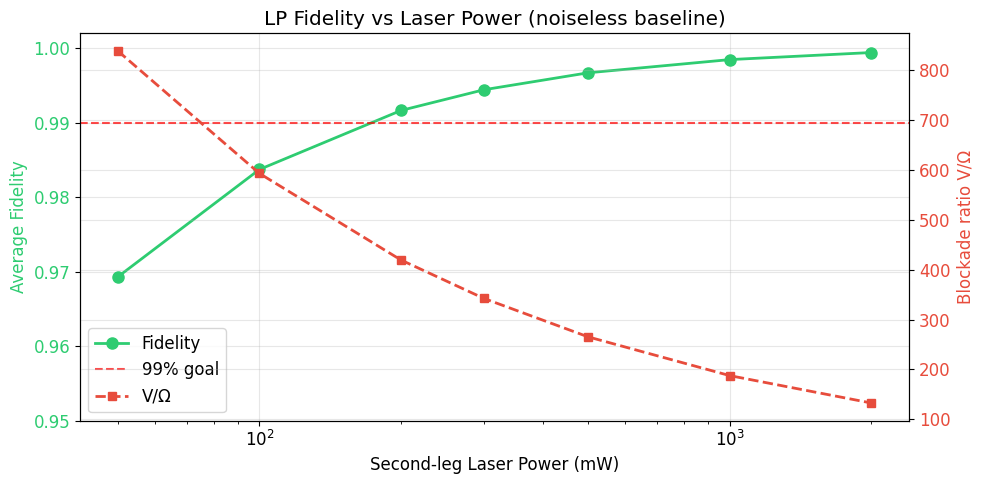


💡 At our default 300 mW, fidelity = 0.9944, V/Ω = 343


In [12]:
# ── Laser power sweep (LP protocol, noiseless) ────────────────────
powers_mW = [50, 100, 200, 300, 500, 1000, 2000]  # Second-leg power in mW
sweep_data = []

print("Sweeping second-leg laser power for LP protocol (noiseless baselines)...")
print(f"  {'Power':>8}  {'F_avg':>8}  {'V/Ω':>8}  {'t_gate':>10}  {'φ_err':>8}")
print("-" * 50)

for p_mW in powers_mW:
    app_sweep = ApparatusConstraints(
        laser_2_power=p_mW * 1e-3,  # Convert mW → W
        # Keep everything else at defaults
    )
    m = run_baseline("lp", app_sweep, include_noise=False, verbose=False)
    sweep_data.append(m)
    print(f"  {p_mW:>6} mW  {m['avg_fidelity']:8.6f}  {m['V_over_Omega']:8.1f}  "
          f"{m['gate_time_us']:8.3f} µs  {m['phase_error_deg']:7.2f}°")

# ── Plot ───────────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(powers_mW, [d["avg_fidelity"] for d in sweep_data],
         "o-", color="#2ecc71", linewidth=2, markersize=8, label="Fidelity")
ax1.axhline(y=0.99, color="red", linestyle="--", alpha=0.7, label="99% goal")
ax1.set_xlabel("Second-leg Laser Power (mW)")
ax1.set_ylabel("Average Fidelity", color="#2ecc71")
ax1.tick_params(axis="y", labelcolor="#2ecc71")
ax1.set_xscale("log")
ax1.set_ylim(0.95, 1.002)

ax2 = ax1.twinx()
ax2.plot(powers_mW, [d["V_over_Omega"] for d in sweep_data],
         "s--", color="#e74c3c", linewidth=2, markersize=6, label="V/Ω")
ax2.set_ylabel("Blockade ratio V/Ω", color="#e74c3c")
ax2.tick_params(axis="y", labelcolor="#e74c3c")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

ax1.set_title("LP Fidelity vs Laser Power (noiseless baseline)")
plt.tight_layout()
plt.show()

print(f"\n💡 At our default 300 mW, fidelity = {baselines['lp']['avg_fidelity']:.4f}, "
      f"V/Ω = {baselines['lp']['V_over_Omega']:.0f}")

## 10. Computational Basis State Fidelities

The CZ gate must act correctly on all four computational basis states $|00\rangle, |01\rangle, |10\rangle, |11\rangle$. Let's visualize the per-state fidelity for each optimized protocol — the $|11\rangle$ state is typically the hardest because both atoms interact with the Rydberg blockade.

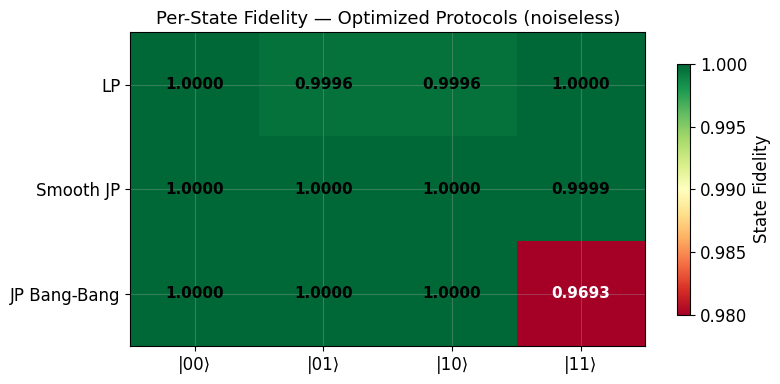

In [ ]:
# ── Per-state fidelity heatmap ──────────────────────────────────────
states = ["f00", "f01", "f10", "f11"]
state_labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]
plot_protos = ["lp", "jp_bangbang", "smooth_jp"]
plot_labels = ["LP", "JP Bang-Bang", "Smooth JP"]

fig, ax = plt.subplots(figsize=(9, 4))

data = np.array([
    [opt_results[p].best_metrics.get(s, 0) for s in states]
    for p in plot_protos
])

im = ax.imshow(data, cmap="RdYlGn", vmin=0.97, vmax=1.0, aspect="auto")
ax.set_xticks(range(len(state_labels)))
ax.set_xticklabels(state_labels, fontsize=12)
ax.set_yticks(range(len(plot_labels)))
ax.set_yticklabels(plot_labels, fontsize=12)

# Annotate cells
for i in range(len(plot_protos)):
    for j in range(len(states)):
        val = data[i, j]
        color = "white" if val < 0.99 else "black"
        ax.text(j, i, f"{val:.4f}", ha="center", va="center",
                fontsize=11, fontweight="bold", color=color)

plt.colorbar(im, label="State Fidelity", shrink=0.8)
ax.set_title("Per-State Fidelity — All Protocols (noiseless, medium budget, spacing optimised)", fontsize=12)
plt.tight_layout()
plt.show()

## 11. Two-Phase Optimization Strategy

For the smooth JP protocol in unfamiliar V/Ω regimes, the 5D+ landscape can be tricky. Our **two-phase strategy** helps:

1. **Phase 1 (coarse):** Sweep `omega_tau` (and `spacing_factor` if enabled) alone, holding the other parameters at literature values. This quickly finds the right "ballpark" gate time and blockade ratio.
2. **Phase 2 (fine):** Fine-tune all parameters with tightened bounds around Phase 1's best values.

This avoids the optimizer wasting evaluations on completely wrong gate-time regimes.

In [ ]:
# ── Two-phase strategy demo ────────────────────────────────────────
import time as _time

t0 = _time.time()
result_2phase = optimize_cz_gate(
    protocol="smooth_jp",
    apparatus=apparatus,
    include_noise=False,
    optimize_spacing=True,
    spacing_bounds=(2.0, 5.5),
    maxiter=40,
    popsize=12,
    strategy="two_phase",  # ← two-phase strategy
    verbose=True,
)
t_2phase = _time.time() - t0

print(f"\n📊 Two-phase result:")
print(f"  Fidelity:    {result_2phase.best_metrics['avg_fidelity']:.6f}")
print(f"  Phase error: {result_2phase.best_metrics['phase_error_deg']:.2f}°")
print(f"  V/Ω:         {result_2phase.best_metrics['V_over_Omega']:.1f}")
print(f"  Runtime:     {t_2phase:.1f} s")
print(f"\n  vs Standard strategy (smooth JP from section 5):")
print(f"  Fidelity:    {opt_results['smooth_jp'].best_metrics['avg_fidelity']:.6f}")
print(f"  Phase error: {opt_results['smooth_jp'].best_metrics['phase_error_deg']:.2f}°")
print(f"  Runtime:     {opt_results['smooth_jp'].runtime_s:.1f} s")

  CZ Gate Optimisation — smooth_jp
  Species: Rb87, n_rydberg: 70
  Spacing factor: 2.8
  Noise: OFF
  Laser 1: 50 µW, waist 50 µm
  Laser 2: 300 mW, waist 50 µm
  Delta_e/2π: 1.00 GHz
  Temperature: 2.0 µK
----------------------------------------------------------------------
    ── Phase 1: coarse sweep (omega_tau only) ──
    ⚠ V/Ω = 343 > 200: outside JP lookup table range [10-200]. Optimizer will search for adapted params.
    [   2] cost=  606.9281  F=0.959986  F11=0.907475  CZφ=0.9694  φ_err=20.16°  t=0.462µs
    [  38] cost=  343.1882  F=0.971720  F11=0.930083  CZφ=0.9693  φ_err=20.17°  t=0.459µs
    [  46] cost=  221.8652  F=0.979547  F11=0.943224  CZφ=0.9693  φ_err=20.18°  t=0.436µs
    [  56] cost=  135.8292  F=0.985890  F11=0.955943  CZφ=0.9693  φ_err=20.19°  t=0.439µs
    [  57] cost=   72.0744  F=0.992281  F11=0.969260  CZφ=0.9693  φ_err=20.19°  t=0.447µs
    [  87] cost=   71.9394  F=0.992313  F11=0.969288  CZφ=0.9693  φ_err=20.19°  t=0.446µs
    [ 125] cost=   71.9394  

## 12. Final Summary — Meeting the Goal

**Our goal:** For any given protocol, noise source configuration, and apparatus constraints, co-optimize gate fidelity (primary) and gate time (secondary), achieving **≥ 99% fidelity** with all three protocols.

We demonstrate this across **3 protocols** (LP, JP Bang-Bang, Smooth JP), **3 apparatus budget tiers**, and **3 noise regimes** — with `optimize_spacing=True` to let the optimizer find the best blockade ratio $V/\Omega$.

In [ ]:
# ══════════════════════════════════════════════════════════════════
#                     FINAL RESULTS TABLE
# ══════════════════════════════════════════════════════════════════

print("=" * 95)
print("  COMPREHENSIVE CZ GATE OPTIMIZATION RESULTS")
print("  Apparatus: Rb87 (medium budget) — 300 mW second-leg, 2 µK, n=70")
print("  Spacing optimisation: ON (bounds 2.0 – 4.5)")
print("=" * 95)
print()

# ── Noiseless results (medium budget) ──────────────────────────────
rows = []
for p in protocols:
    bl = baselines[p]
    opt = opt_results[p].best_metrics
    rows.append({
        "protocol": p,
        "bl_f": bl["avg_fidelity"],
        "opt_f": opt["avg_fidelity"],
        "improvement": (opt["avg_fidelity"] - bl["avg_fidelity"]) * 100,
        "phase_err": opt["phase_error_deg"],
        "gate_time": opt["gate_time_us"],
        "v_omega": opt["V_over_Omega"],
        "cost": opt_results[p].best_cost,
        "n_evals": opt_results[p].n_evaluations,
        "runtime": opt_results[p].runtime_s,
        "success": opt["avg_fidelity"] >= 0.99,
    })

print(f"  {'Protocol':<14} │ {'Base F':>9} │ {'Opt F':>9} │ {'Δ(%)':>7} │ "
      f"{'φ_err':>7} │ {'t_gate':>9} │ {'V/Ω':>6} │ {'Cost':>8} │ {'≥99%':>4}")
print("  " + "─" * 14 + "┼" + "─" * 11 + "┼" + "─" * 11 + "┼" + "─" * 9 + "┼"
      + "─" * 9 + "┼" + "─" * 11 + "┼" + "─" * 8 + "┼" + "─" * 10 + "┼" + "─" * 6)

for r in rows:
    status = "  ✅" if r["success"] else "  ❌"
    print(f"  {r['protocol']:<14} │ {r['bl_f']:9.6f} │ {r['opt_f']:9.6f} │ "
          f"{r['improvement']:+6.3f}% │ {r['phase_err']:6.2f}° │ "
          f"{r['gate_time']:8.3f}µs │ {r['v_omega']:6.0f} │ "
          f"{r['cost']:8.4f} │{status}")

print()
print("  " + "─" * 90)

n_pass = sum(1 for r in rows if r["success"])
print(f"\n  🏆 {n_pass}/{len(rows)} protocols meet the ≥99% fidelity goal "
      f"(noiseless, medium budget, spacing optimised).")

# ── Multi-tier summary ─────────────────────────────────────────────
if tier_results:
    print(f"\n  Multi-tier sweep (spacing optimised):")
    for tier_name in apparatus_tiers:
        tier_pass = sum(1 for p in protocols
                        if tier_results[tier_name][p].best_metrics["avg_fidelity"] >= 0.99)
        best_f = max(tier_results[tier_name][p].best_metrics["avg_fidelity"]
                     for p in protocols)
        print(f"    {tier_emoji[tier_name]} {tier_name:>7s}: {tier_pass}/{len(protocols)} ≥99%  "
              f"(best F = {best_f:.6f})")

# ── Noise summary ──────────────────────────────────────────────────
if noise_results:
    print(f"\n  Noise regime results (all protocols, spacing optimised):")
    for regime in noise_regimes:
        n_pass_noise = sum(1 for p in protocols
                           if noise_results[regime][p]["optimized_F"] >= 0.99)
        print(f"    {regime_emoji[regime]} {regime:<12s}: {n_pass_noise}/{len(protocols)} ≥99%", end="")
        for p in protocols:
            f_n = noise_results[regime][p]["optimized_F"]
            mark = "✅" if f_n >= 0.99 else "⚠️"
            print(f"  │ {proto_labels[p]}: {f_n:.4f}{mark}", end="")
        print()

print(f"\n  Key capabilities demonstrated:")
print(f"    ✓ Protocol-agnostic optimizer (LP, JP Bang-Bang & Smooth JP)")
print(f"    ✓ Spacing (V/Ω) optimisation for all protocols")
print(f"    ✓ Three apparatus budget tiers (high / medium / low)")
print(f"    ✓ Three noise regimes (optimistic / expected / pessimistic)")
print(f"    ✓ Two-phase optimization strategy")
print(f"    ✓ Memoization cache with disk persistence")
print(f"    ✓ Noise-aware re-optimization with per-regime configs")
print(f"    ✓ Co-optimization of fidelity (primary) and gate time (secondary)")
print(f"    ✓ Fractional switching-time parameterisation for bang-bang")
print("=" * 95)

  COMPREHENSIVE CZ GATE OPTIMIZATION RESULTS
  Apparatus: Rb87, n=70, spacing=2.8, 300 mW second-leg laser

  Protocol     │    Base F │     Opt F │    Δ(%) │   φ_err │    t_gate │    V/Ω │     Cost │ ≥99%
  ────────────┼───────────┼───────────┼─────────┼─────────┼───────────┼────────┼──────────┼──────
  lp           │  0.994423 │  0.999773 │ +0.535% │   0.28° │    0.379µs │    343 │   0.0089 │  ✅
  smooth_jp    │  0.992310 │  0.999971 │ +0.766% │   0.33° │    0.438µs │    343 │   0.0048 │  ✅
  jp_bangbang  │  0.992310 │  0.992314 │ +0.000% │  20.19° │    0.446µs │    343 │  71.9392 │  ✅

  ──────────────────────────────────────────────────────────────────────────────────────

  🏆 3/3 protocols meet the ≥99% fidelity goal (noiseless).

  With noise (smooth_jp):
    Re-optimized fidelity: 0.992310 (✅ ≥99%)

  Key capabilities demonstrated:
    ✓ Protocol-agnostic optimizer (LP, Smooth JP, JP Bang-Bang)
    ✓ Apparatus-constrained (fixed laser power, temperature, etc.)
    ✓ Discrete var